## Ontologia com RDFLib + SPARQL

Este notebook contém:
- **Construção da ontologia** (classes, propriedades, indivíduos)
- **Consultas SPARQL** (SELECT/CONSTRUCT/ASK)
- **Inferência RDFS/OWL**
- **Visualizações** (NetworkX/Matplotlib, PyVis)

> Execute as células na ordem. Se estiver em um ambiente novo, execute primeiro a **instalação** das dependências.


## Montagem do Grafo

### Passo 1: Importações principais e setup

- Importa bibliotecas (`rdflib`, `networkx`, `matplotlib` e `pyvis`).
- Prepara utilitários (por exemplo, `Namespace`, `Literal`) usados na modelagem RDF/OWL.

In [1]:
from rdflib import Graph, Namespace, Literal, RDF, RDFS, OWL, XSD
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from owlrl import DeductiveClosure, RDFS_Semantics, OWLRL_Semantics

### Passo 2: Criando o grafo RDF e definindo Namespaces

- Cria um grafo `rdflib.Graph()` que armazenará triplas RDF.
- Define o namespace base `ex:` (ex.: `http://example.org/`) e faz `bind` para facilitar a leitura nas consultas/serializações.

In [32]:
g = Graph()
EX = Namespace("http://example.org/")
g.bind("ex", EX)
g.bind("rdf", RDF)
g.bind("rdfs", RDFS)
g.bind("owl", OWL)

### Passo 3: Definindo classes da ontologia

- Declara classes `ex:Pessoa`, `ex:Artigo`, `ex:Instituicao`.
- Define hierarquia de classe, como `ex:Pesquisador rdfs:subClassOf ex:Pessoa`.

In [33]:
g.add((EX.Pessoa,       RDF.type, OWL.Class))
g.add((EX.Artigo,       RDF.type, OWL.Class))
g.add((EX.Instituicao,  RDF.type, OWL.Class))

g.add((EX.Pesquisador, RDF.type, OWL.Class))
g.add((EX.Pesquisador, RDFS.subClassOf, EX.Pessoa))

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

### Passo 4: Definindo propriedades de objeto e suas restrições

- Declara as propriedades `ex:autorDe` e `ex:afiliadoA`.
- Define `rdfs:domain` e `rdfs:range` para cada propriedade (validação conceitual).

In [34]:
g.add((EX.autorDe,    RDF.type, OWL.ObjectProperty))
g.add((EX.autorDe,    RDFS.domain, EX.Pessoa))
g.add((EX.autorDe,    RDFS.range,  EX.Artigo))

g.add((EX.afiliadoA,  RDF.type, OWL.ObjectProperty))
g.add((EX.afiliadoA,  RDFS.domain, EX.Pessoa))
g.add((EX.afiliadoA,  RDFS.range,  EX.Instituicao))

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

### Passo 5: Declarando identificadores (URIRefs) para indivíduos no namespace `ex:`

- `EX` é um `Namespace` do RDFLib. Ao escrever `EX.Bernardo`, obtemos um `URIRef("http://example.org/Bernardo")`.
  O mesmo vale para `EX.Giovanna`, `EX.ArtigoIA`, `EX.ArtigoBI`, `EX.UFRJ`, `EX.ITLAB` etc.

In [35]:
bernardo  = EX.Bernardo
giovanna  = EX.Giovanna
claudio   = EX.Claudio
carla     = EX.Carla

art1 = EX.ArtigoIA
art2 = EX.ArtigoBI

ufrj = EX.UFRJ
itlab = EX.ITLAB

### Passo 6: Declarando tipagem dos indivíduos

- Cada linha `g.add((s, RDF.type, C))` adiciona a tríplice `s rdf:type C` (em Turtle: `s a C .`), por exemplo: Bernardo/Carla → `ex:Pesquisador`, Giovanna/Cláudio → `ex:Pessoa`, ArtigoIA/ArtigoBI → `ex:Artigo`, UFRJ/ITLAB → `ex:Instituicao`.

In [36]:
g.add((bernardo, RDF.type, EX.Pesquisador))
g.add((giovanna, RDF.type, EX.Pessoa))
g.add((claudio,  RDF.type, EX.Pessoa))
g.add((carla,    RDF.type, EX.Pesquisador))

g.add((art1,  RDF.type, EX.Artigo))
g.add((art2,  RDF.type, EX.Artigo))
g.add((ufrj,  RDF.type, EX.Instituicao))
g.add((itlab, RDF.type, EX.Instituicao))

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

### Passo 7: Definindo rótulo dos indivíduos

- Cada linha insere a tríplice `s rdfs:label "Texto"` (ex.: Bernardo → `"Bernardo"`, ArtigoIA → `"Artigo de IA"`, UFRJ → `"UFRJ"`).
- Isso facilita exibição em consultas/visualizações (ex.: `OPTIONAL { ?s rdfs:label ?label }`) e não muda a identidade (URI) nem a classe do recurso.

In [37]:
g.add((bernardo, RDFS.label, Literal("Bernardo")))
g.add((giovanna, RDFS.label, Literal("Giovanna")))
g.add((claudio,  RDFS.label, Literal("Claudio")))
g.add((carla,    RDFS.label, Literal("Carla")))
g.add((art1,     RDFS.label, Literal("Artigo de IA")))
g.add((art2,     RDFS.label, Literal("Artigo de BI")))
g.add((ufrj,     RDFS.label, Literal("UFRJ")))
g.add((itlab,    RDFS.label, Literal("ITLAB")))

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

### Passo 8: Adicionando relacionamentos entre indivíduos

- Conecta pessoas a instituições (`ex:afiliadoA`) e pessoas a artigos (`ex:autorDe`).
- Essas arestas serão úteis nas consultas SPARQL e visualizações.

In [38]:
g.add((bernardo, EX.afiliadoA, ufrj))
g.add((giovanna, EX.afiliadoA, ufrj))
g.add((claudio,  EX.afiliadoA, itlab))
g.add((carla,    EX.afiliadoA, itlab))

g.add((bernardo, EX.autorDe, art1))
g.add((giovanna, EX.autorDe, art1))
g.add((giovanna, EX.autorDe, art2))
g.add((claudio,  EX.autorDe, art2))
g.add((carla,    EX.autorDe, art1))

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

### Passo 9: Inferência

- Verifica se uma condição é verdadeira. Ex.: Se `Bernardo` é `Pessoa`.

In [39]:
DeductiveClosure(RDFS_Semantics).expand(g)
q = """
PREFIX ex: <http://example.org/>
ASK { ex:Bernardo a ex:Pessoa. }
"""
print(bool(g.query(q).askAnswer))

True


### Passo 10: Serializando o grafo para Turtle

- Salva o grafo no arquivo `ontologia_turtle.ttl` (formato Turtle).

In [40]:
g.serialize("ontologia_turtle.ttl", format="turtle")

<Graph identifier=Nff0ec386d6b94850bd872d383731c345 (<class 'rdflib.graph.Graph'>)>

## Consultas SPARQL

### Exemplo 1: Consultando artigos de uma pessoa específica

- Recupera artigos associados a `ex:Bernardo` via `ex:autorDe`.

In [41]:
q = """
PREFIX ex: <http://example.org/>
SELECT ?art ?artLabel
WHERE {
  ex:Bernardo ex:autorDe ?art .
  OPTIONAL { ?art rdfs:label ?artLabel }
}
"""
for row in g.query(q):
    print(row.artLabel or row.art)

Artigo de IA


### Exemplo 2: Listando pessoas da mesma instituição

- Recupera indivíduos com a mesma afiliação institucional que uma pessoa de referência (`ex:Bernardo`).

In [42]:
q = """
PREFIX ex: <http://example.org/>
SELECT DISTINCT ?p ?nome ?instNome
WHERE {
  ex:Bernardo ex:afiliadoA ?inst .
  ?p          ex:afiliadoA ?inst .
  FILTER (?p != ex:Bernardo)
  OPTIONAL { ?p rdfs:label ?nome }
  OPTIONAL { ?inst rdfs:label ?instNome }
}
ORDER BY ?nome
"""
for row in g.query(q):
    print(f"{row.nome or row.p} (na {row.instNome})")

Giovanna (na UFRJ)


### Exemplo 3: Listando autores de um artigo específico

- Dado um artigo (`ex:ArtigoIA`), retorna seus (co)autores.

In [43]:
q = """
PREFIX ex: <http://example.org/>
SELECT ?p ?nome
WHERE {
  ?p ex:autorDe ex:ArtigoIA .
  OPTIONAL { ?p rdfs:label ?nome }
}
ORDER BY ?nome
"""
for row in g.query(q):
    print(row.nome or row.p)

Bernardo
Carla
Giovanna


## Visualização do Grafo

### Passo 1: Visualização estática do grafo (NetworkX + Matplotlib)

- Constrói um grafo dirigido/multiaresta a partir de triplas.
- Desenha nós e rótulos; exibe labels de arestas (predicados).

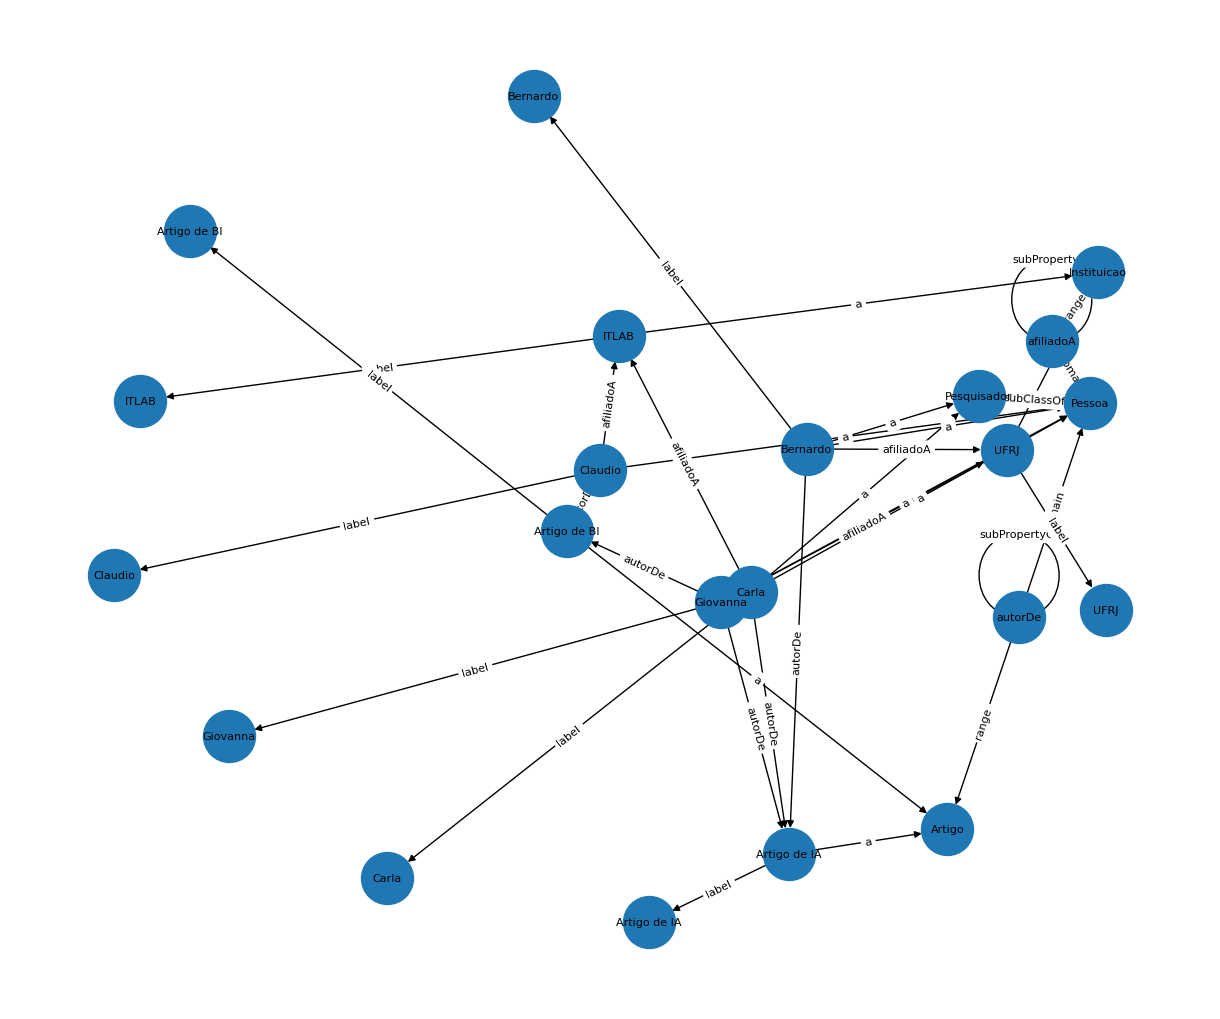

In [44]:
def short(u):
    s = str(u)
    if "#" in s: return s.split("#")[-1]
    if "/" in s: return s.rstrip("/").split("/")[-1]
    return s

def label_for(u):
    lbl = next(g.objects(u, RDFS.label), None)
    return str(lbl) if lbl else short(u)

def in_ex(u): return str(u).startswith(str(EX))

G = nx.MultiDiGraph()
for s,p,o in g.triples((None,None,None)):
    if o.__class__.__name__ == "Literal":
        o_node = f'"{o}"'
        G.add_node(o_node, label=str(o))
        G.add_edge(s, o_node, label=short(p))
    else:
        if in_ex(s) and in_ex(o):
            G.add_node(s, label=label_for(s))
            G.add_node(o, label=label_for(o))
            edge_label = "a" if p == RDF.type else short(p)
            G.add_edge(s, o, label=edge_label)
            
pos = nx.spring_layout(G, seed=42)
node_labels = {n: G.nodes[n].get("label", short(n)) for n in G.nodes()}
edge_labels = {(u,v,k): d.get("label","") for u,v,k,d in G.edges(keys=True, data=True)}

plt.figure(figsize=(12,10))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1400, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.savefig("grafo_rdf.png")
plt.show()

### Passo 2: Visualização interativa do grafo (pyviz)

- Constrói um grafo dirigido/multiaresta a partir de triplas.
- Desenha nós e rótulos; exibe labels de arestas (predicados).

In [45]:
net = Network(height="800px", width="100%", notebook=True, directed=True, select_menu=True)

nodes = set()
for (s,p,o) in g.triples((None,None,None)):
    if o.__class__.__name__ != "Literal":
        nodes.add(s); nodes.add(o)

for n in nodes:
    net.add_node(str(n), label=label_for(n))

for (s,p,o) in g.triples((None,None,None)):
    if o.__class__.__name__ != "Literal":
        lab = "a" if str(p).endswith("type") else p.split("#")[-1].split("/")[-1]
        net.add_edge(str(s), str(o), label=lab)

net.show("grafo_interativo.html", notebook=False)

grafo_interativo.html
